In [1]:
from collections import defaultdict, Counter
import pandas as pd
from matplotlib import pyplot as pl
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from statsmodels.stats.multitest import fdrcorrection as benjamini_hochberg

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
plates = ['P1', 'P2', 'P3']
plate2env = {'P1': 'YPD 30C', 'P2': 'SC 30C', 'P3': 'SC 37C'}
strains = ['diploid', 'alpha', 'a']
strains_for_print = {'a': '$MATa$', 'diploid': 'Diploid', 'alpha': r'$MAT\alpha$'}
color_by_strain = {'diploid': 'k', 'alpha': '#FFB000', 'a': '#648FFF'}
seq_gens = [70, 1410, 2640, 5150, 7530, 10150]
all_wells = sorted([i.split('/')[-1].split('_')[0] for i in glob('../../Output/WGS/combined_option/processed_well_output/*_processed.tsv')])
wells = [w for w in all_wells if w!='P1B03'] #P1B03 excluded because it is a haploid population that diploidized
o2g = {i[0]:i[1] for i in pd.read_csv('../accessory_files/yeast_gene_annotations.tsv', delimiter='\t').as_matrix(['ORF', 'Gene_ORF'])}
wellinfo = pd.read_csv('../accessory_files/VLTE_by_well_info.csv')[['plate.well', 'contam', 'strain']]
wellinfo['plate.well'] = wellinfo['plate.well'].apply(lambda p: p[:2]+p[3:]) #reformatting to match for merge
well2strain = {i[0]:i[1] for i in wellinfo.as_matrix(['plate.well', 'strain'])}

In [3]:
def simpler_get_gene_hit_probs(data, pop_hits):
    gene_hits = data.sum(axis=1)# pops w/ this gene hit, N_i
    return np.tile(gene_hits / len(pop_hits), (len(pop_hits), 1)).T

def simpler_split_probs(pop_hits, mhd, well_sets):
    # given sets of well indices, computes hit probabilities separately for each set, 
    # then stitches them back together in order
    well_to_probs = dict()
    full_probs = np.zeros_like(mhd*1.1) # multiplication to force it to be a float array
    for well_set in well_sets:
        full_probs[:,well_set] = simpler_get_gene_hit_probs(mhd[:,well_set], pop_hits[well_set])
    return full_probs


# Mutual information

In [4]:
def calculate_MI(hit_data, pseud_factor=1):
    K = len(orf_names)
    MI_by_orf_pair = np.zeros((K, K))
    for p in plates:
        for s in strains:
            well_indices = [w for w in range(len(wells)) if wells[w][:2]==p and well2strain[wells[w]]==s]
            hit_table = np.clip(hit_data[:,well_indices], 0, 1) # M_gi in Fisher
            gene_hit_sums = np.sum(hit_table, axis=1)
            # I use this to exclude MI information from genes with no hits in this strain / environment combination
            mutations_possible = np.clip(np.tile(gene_hit_sums, (K, 1)).T * np.tile(gene_hit_sums, (K, 1)), 0, 1)
            e = pseud_factor/np.sum(hit_table) # epsilon, psuedocount
            tdat = hit_table + e # ~M_gi (M with tilde on top)
            tdat_no_hit = (1+e-tdat)
            jointprobs = dict()
            independence_probs = dict()
            Cm = len(well_indices)*(1+e)
            Cj = len(well_indices)*((1+e)**2)
            cross_probs = (tdat @ tdat.T) # ~M_gi * ~M_gj
            jointprobs['both'] = cross_probs / Cj
            i_probs = np.tile(np.diagonal(cross_probs), (K, 1)).T / Cm # P(sig_i=1)
            j_probs = np.tile(np.diagonal(cross_probs), (K, 1)) / Cm   # P(sig_j=1)
            jointprobs['i_only'] = (tdat_no_hit @ tdat.T) / Cj
            jointprobs['j_only'] = (tdat @ tdat_no_hit.T) / Cj
            jointprobs['neither'] = (tdat_no_hit @ tdat_no_hit.T) / Cj
            independence_probs['both'] = i_probs * j_probs
            independence_probs['i_only'] = i_probs *  (1 - j_probs)
            independence_probs['j_only'] = (1 - i_probs) *  j_probs
            independence_probs['neither'] = (1 - i_probs) *  (1 - j_probs)
            for outcome in jointprobs:
                MI_by_orf_pair += mutations_possible*np.nan_to_num(np.log2(jointprobs[outcome]/independence_probs[outcome])*jointprobs[outcome])
    return MI_by_orf_pair

def draw_data(probs):
    draw = np.random.rand(probs.shape[0], probs.shape[1])
    return np.where(draw<probs, 1, 0)

def simulate_MI(n, probs_to_sim, pseud_factor=1):
    # keep record of total MI and max MI for each run
    MI_rec = []
    for run in range(n):
        sim = draw_data(probs_to_sim)
        MI_mat = calculate_MI(sim, pseud_factor=pseud_factor)
        MI_mat = MI_mat*np.tril(np.ones_like(MI_mat), k=-1) # set diag and up to zero
        MI_rec.append([np.sum(MI_mat), np.max(MI_mat)])
    return MI_rec, MI_mat, sim



In [5]:
# a dataframe with hits and multiplicity for each ORF in the yeast genome
orf_hit_df = pd.read_csv('../../Output/WGS/combined_option/gene_hit_data.tsv', delimiter='\t')

In [6]:
pop_hits = np.sum(np.clip(orf_hit_df[wells], 0, 1), axis=0)
multi_hit_data = orf_hit_df[orf_hit_df['pops_hit']>=6]
orf_names = list(multi_hit_data['ORF'])
mh_dat = np.clip(np.array(multi_hit_data[wells]), 0, 1)

In [7]:
# here we fit probabilities of mutations happening in each background-environment combination using the data
model4_probs = simpler_split_probs(pop_hits, mh_dat, [[w for w in range(len(wells)) if wells[w][:2]==p and well2strain[wells[w]]==s] for p in plates for s in strains])
# then we simulate mutations using this data, and calculate MI between multi-hit ORFs, recording the MI sum and max MI
sim_res, sim_example, sim = simulate_MI(10000, model4_probs)
# we calculate MI between multi-hit orfs in our data
MI_results = calculate_MI(mh_dat)
MI_results2 = MI_results*np.tril(np.ones_like(MI_results), k=-1) # set diag and up to zero
print('Data MI sum:', np.sum(MI_results2), 'Data MI max:', np.max(MI_results2))

Data MI sum: 14637.620115585936 Data MI max: 9.058517469735039


MI_tot P = 0.0325


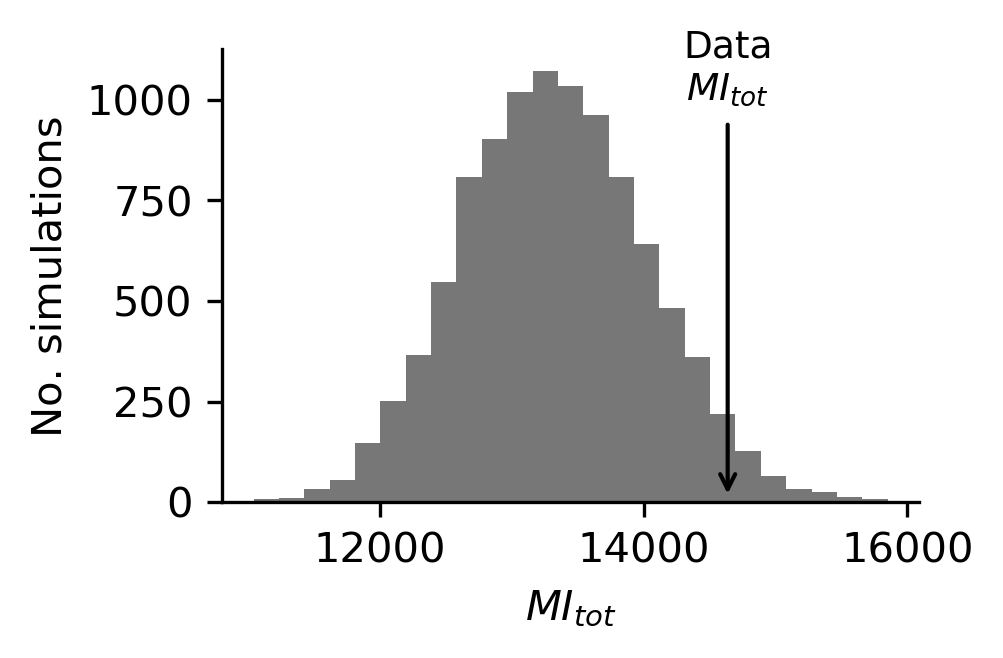

In [8]:
f, sub = pl.subplots(1, 1, figsize=(3, 2), dpi=300)
sub.hist([s[0] for s in sim_res], bins=25, facecolor='#777777')
sub.annotate('Data\n$MI_{tot}$', xy=(np.sum(MI_results2), 0), xytext=(np.sum(MI_results2), 1000), xycoords="data", ha='center', annotation_clip=False, arrowprops=dict(arrowstyle='->', lw=1), fontsize=9)
print('MI_tot P =', len([s[1] for s in sim_res if s[0]>np.sum(MI_results2)])/len(sim_res))
sub.set_ylabel('No. simulations')
sub.set_xlabel('$MI_{tot}$')
sns.despine()

f.savefig('../../Output/Figs/supp_figs/MI.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
f.savefig('../../Output/Figs/supp_figs/MI.svg', background='transparent', bbox_inches='tight', pad_inches=0.1)

MI_tot P = 0.0325
MI_max P = 0.8059


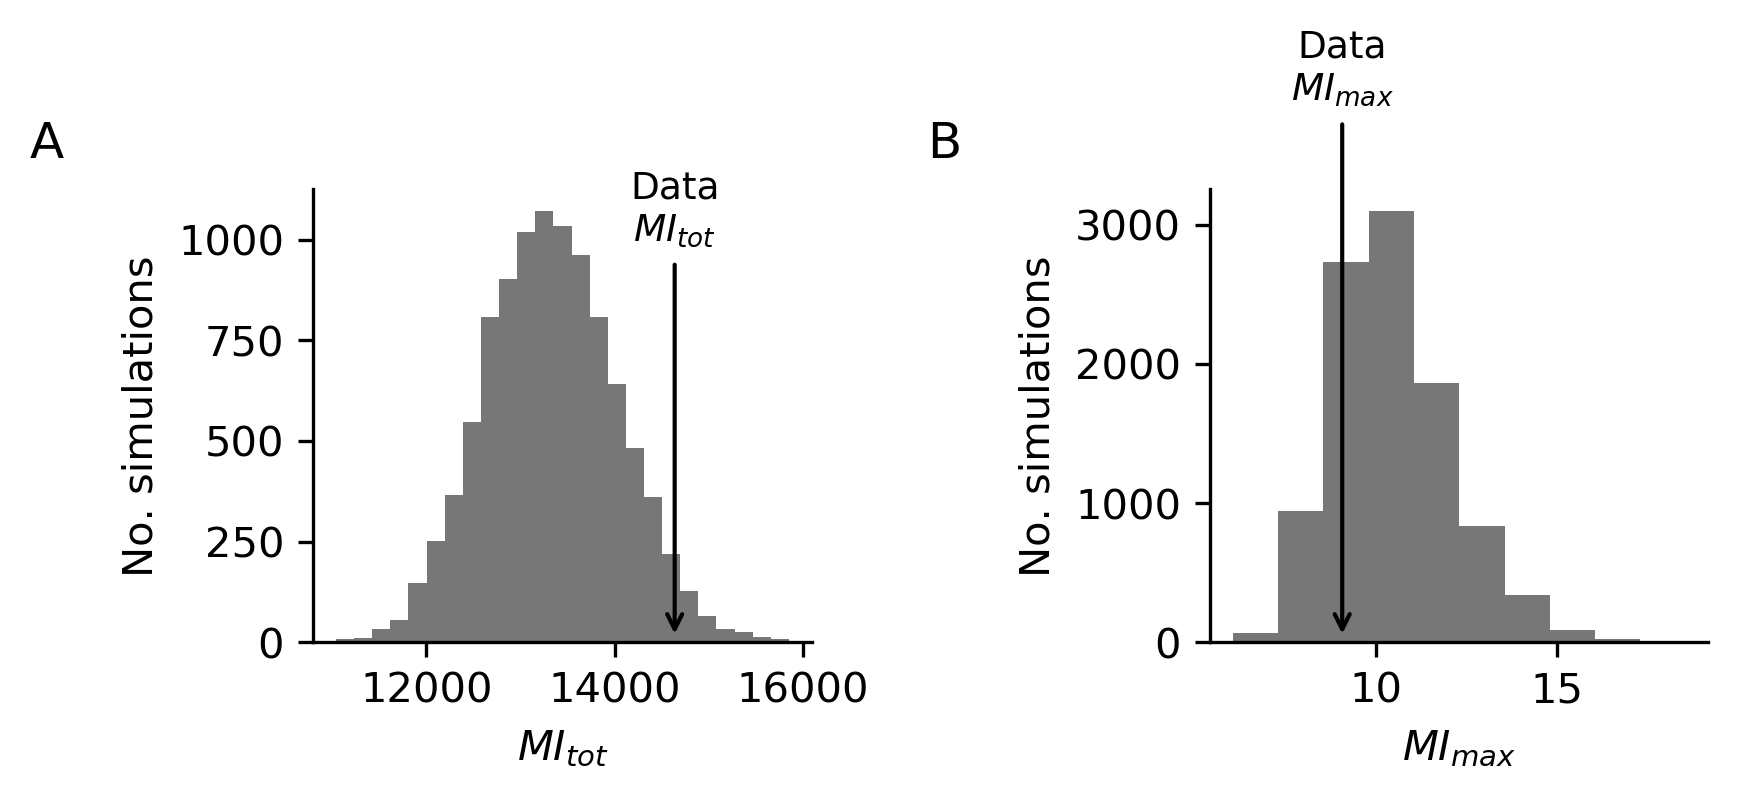

In [9]:
f, subs = pl.subplots(1, 2, figsize=(6, 2), dpi=300)
pl.subplots_adjust(wspace=0.8)
subs[0].hist([s[0] for s in sim_res], bins=25, facecolor='#777777')
subs[0].annotate('Data\n$MI_{tot}$', xy=(np.sum(MI_results2), 0), xytext=(np.sum(MI_results2), 1000), xycoords="data", ha='center', annotation_clip=False, arrowprops=dict(arrowstyle='->', lw=1), fontsize=9)
print('MI_tot P =', len([s[1] for s in sim_res if s[0]>np.sum(MI_results2)])/len(sim_res))
subs[1].hist([s[1] for s in sim_res], facecolor='#777777')
subs[1].annotate('Data\n$MI_{max}$', xy=(np.max(MI_results2), 0), xytext=(np.max(MI_results2), 3900), xycoords="data", ha='center', annotation_clip=False, arrowprops=dict(arrowstyle='->', lw=1), fontsize=9)
print('MI_max P =', len([s[1] for s in sim_res if s[1]>np.max(MI_results2)])/len(sim_res))
subs[0].set_ylabel('No. simulations')
subs[0].set_xlabel('$MI_{tot}$')
subs[1].set_ylabel('No. simulations')
subs[1].set_xlabel('$MI_{max}$')
subs[0].annotate('A', xy=(-0.5, 1.1), xycoords="axes fraction", ha='right', va='center', fontsize=12)
subs[1].annotate('B', xy=(-0.5, 1.1), xycoords="axes fraction", ha='right', va='center', fontsize=12)
sns.despine()

f.savefig('../../Output/Figs/supp_figs/MI_w_max.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

# Showing that this isn't wildly dependent on the choice of epsilon, as in Fisher (though we are close to the 0.05 significance threshold here)

In [10]:
sims = dict()
datas = dict()
possible_pseuds = [i*0.1 for i in range(1, 21)]
for pseud in possible_pseuds:
    if pseud % 1 == 0:
        print(pseud)
    sims[pseud] = simulate_MI(1000, model4_probs, pseud_factor=pseud)
    datas[pseud] = calculate_MI(mh_dat, pseud_factor=pseud)*np.tril(np.ones_like(MI_results), k=-1)


1.0
2.0


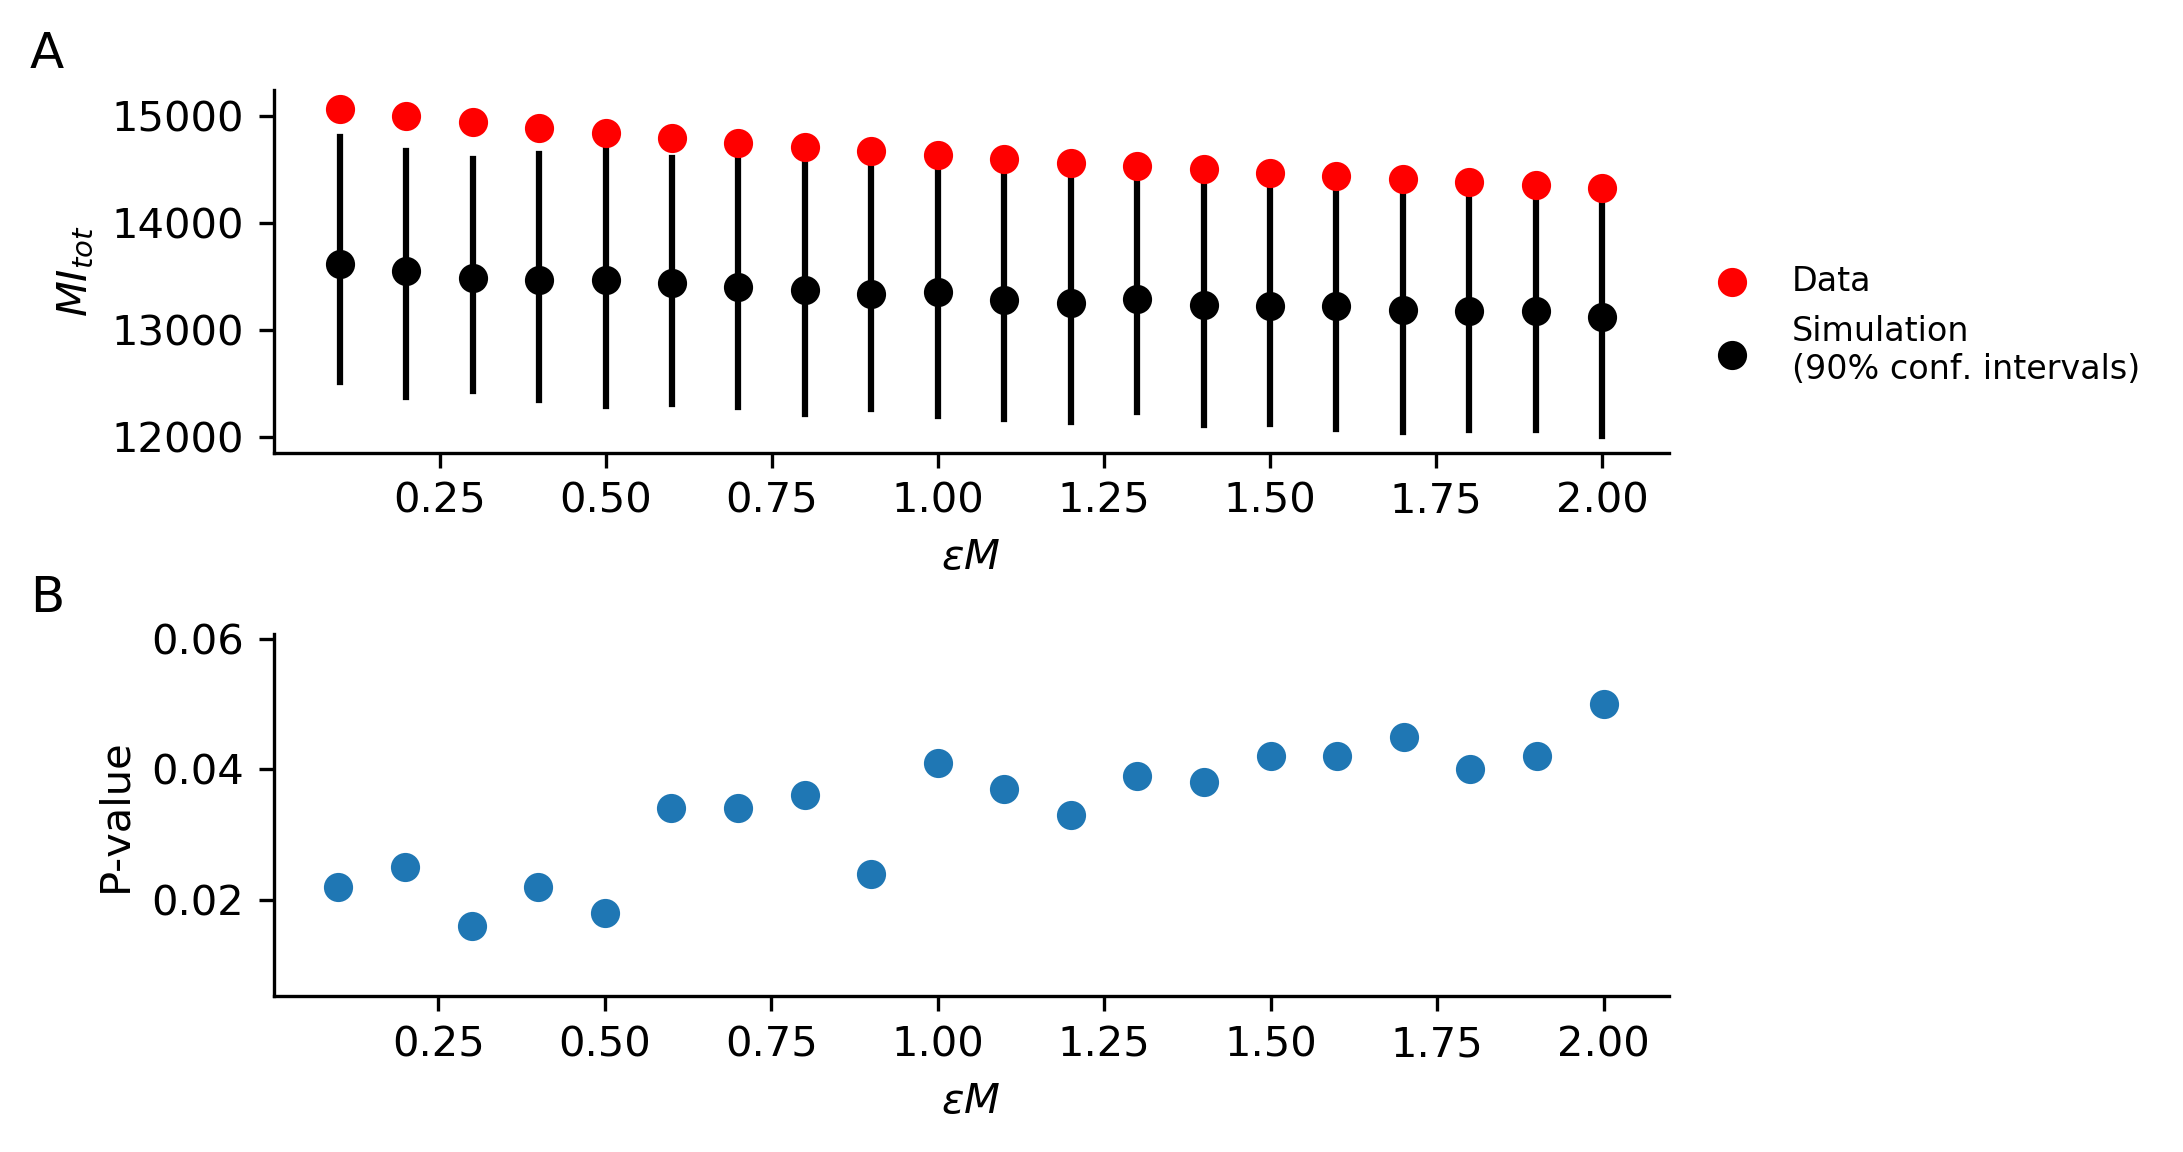

In [11]:
f,subs = pl.subplots(2,1, figsize=(6,4), dpi=300)
pl.subplots_adjust(hspace=0.5)
ps = []
for p in possible_pseuds:
    all_results = sorted([np.sum(s) for s in sims[p][0]])
    subs[0].plot([p, p], [all_results[int(len(all_results)*0.05)], all_results[-int(len(all_results)*0.05)]], c='k', zorder=-1)
    subs[0].scatter([p], [np.mean(all_results)], c='k')
    ps.append(len([i for i in all_results if i>=np.sum(datas[p])])/len(all_results))
subs[0].scatter(possible_pseuds, [np.sum(datas[i]) for i in possible_pseuds], c='r', zorder=1, label='Data')
subs[1].scatter(possible_pseuds, ps)
subs[0].set_ylabel('$MI_{tot}$')
subs[0].set_xlabel('$\epsilon M$')
subs[1].set_ylabel('P-value')
subs[1].set_xlabel('$\epsilon M$')
subs[0].scatter([], [], c='k', label='Simulation\n(90% conf. intervals)')
subs[0].legend(frameon=False, bbox_to_anchor=(1, 0.6), fontsize=8)
sns.despine()
subs[0].annotate('A', xy=(-0.15, 1.1), xycoords="axes fraction", ha='right', va='center', fontsize=12)
subs[1].annotate('B', xy=(-0.15, 1.1), xycoords="axes fraction", ha='right', va='center', fontsize=12)

f.savefig('../../Output/Figs/supp_figs/MI_epsilon_changes.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

# Looking at the difference between a simulated MI distrib and a data one:

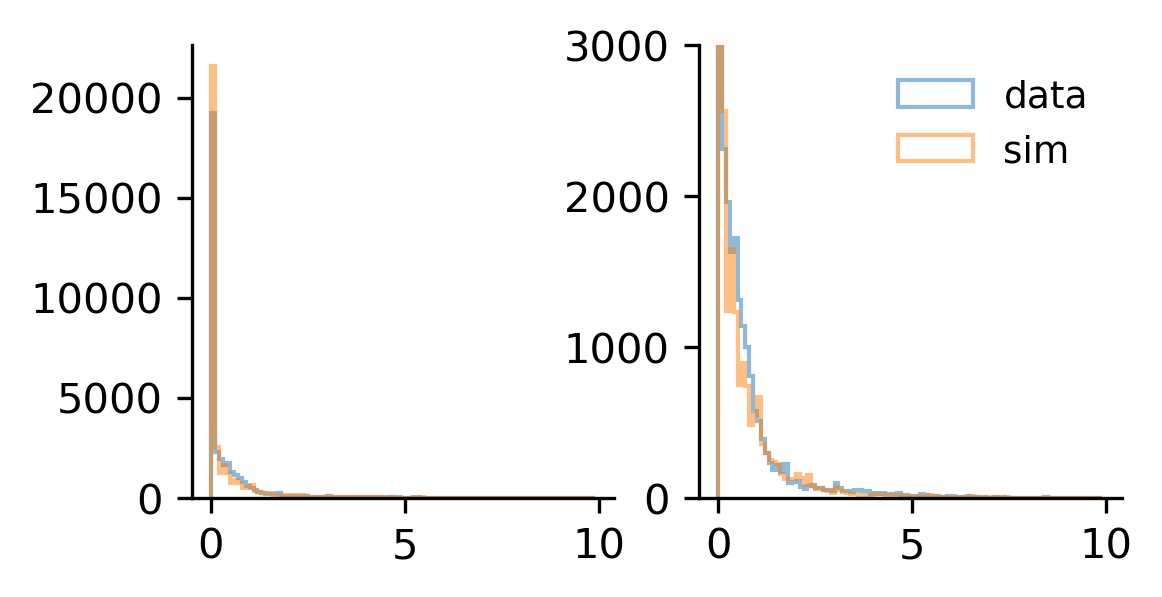

In [12]:
f,subs = pl.subplots(1,2, figsize=(4,2), dpi=300)
subs[0].hist(MI_results2.flatten(), alpha=0.5, bins=[i*0.1 for i in range(100)], histtype=u'step')
subs[0].hist(sim_example.flatten(), alpha=0.5, bins=[i*0.1 for i in range(100)], histtype=u'step')
subs[1].hist(MI_results2.flatten(), alpha=0.5, bins=[i*0.1 for i in range(100)], histtype=u'step', label='data')
subs[1].hist(sim_example.flatten(), alpha=0.5, bins=[i*0.1 for i in range(100)], histtype=u'step', label='sim')
subs[1].legend(frameon=False, fontsize=9)
subs[1].set_ylim([0, 3000])
sns.despine()

# Let's look at which mutations have the most MI even though it's not significant:

In [13]:
tmp = []
for i in range(len(orf_names)):
    for j in range(len(orf_names)):
        if i > j:
            tmp.append([o2g.get(orf_names[i], orf_names[i]), o2g.get(orf_names[j], orf_names[j]), MI_results2[i,j]])
td = pd.DataFrame(tmp, columns=['ORF1', 'ORF2', 'MI'])
td.sort_values(by='MI', ascending=False).iloc[:10]

,ORF1,ORF2,MI
44,ADE6,"ADE5,7",9.058517
5902,RPO21,HSP104,8.485329
3256,IRA1,HSP104,8.471599
1548,ADE4,"ADE5,7",8.416255
8144,SUR1,HSP104,8.322009
10894,TRA1,HSP104,8.086108
10456,OAF1,HSP104,7.874165
1241,BEM2,HSP104,7.816688
3586,ESL1,HSP104,7.718958
2355,SNT1,ADE6,7.680615


In [14]:
for i in range(5,10):
    print(i, len(td[td['MI']>i]), len([m for m in sim_example.flatten() if m>=i])/len(sim_example.flatten()))

5 198 0.00439517370734302
6 68 0.001651689482377313
7 19 0.0005598947397889197
8 6 0.00013997368494722993
9 1 2.7994736989445986e-05


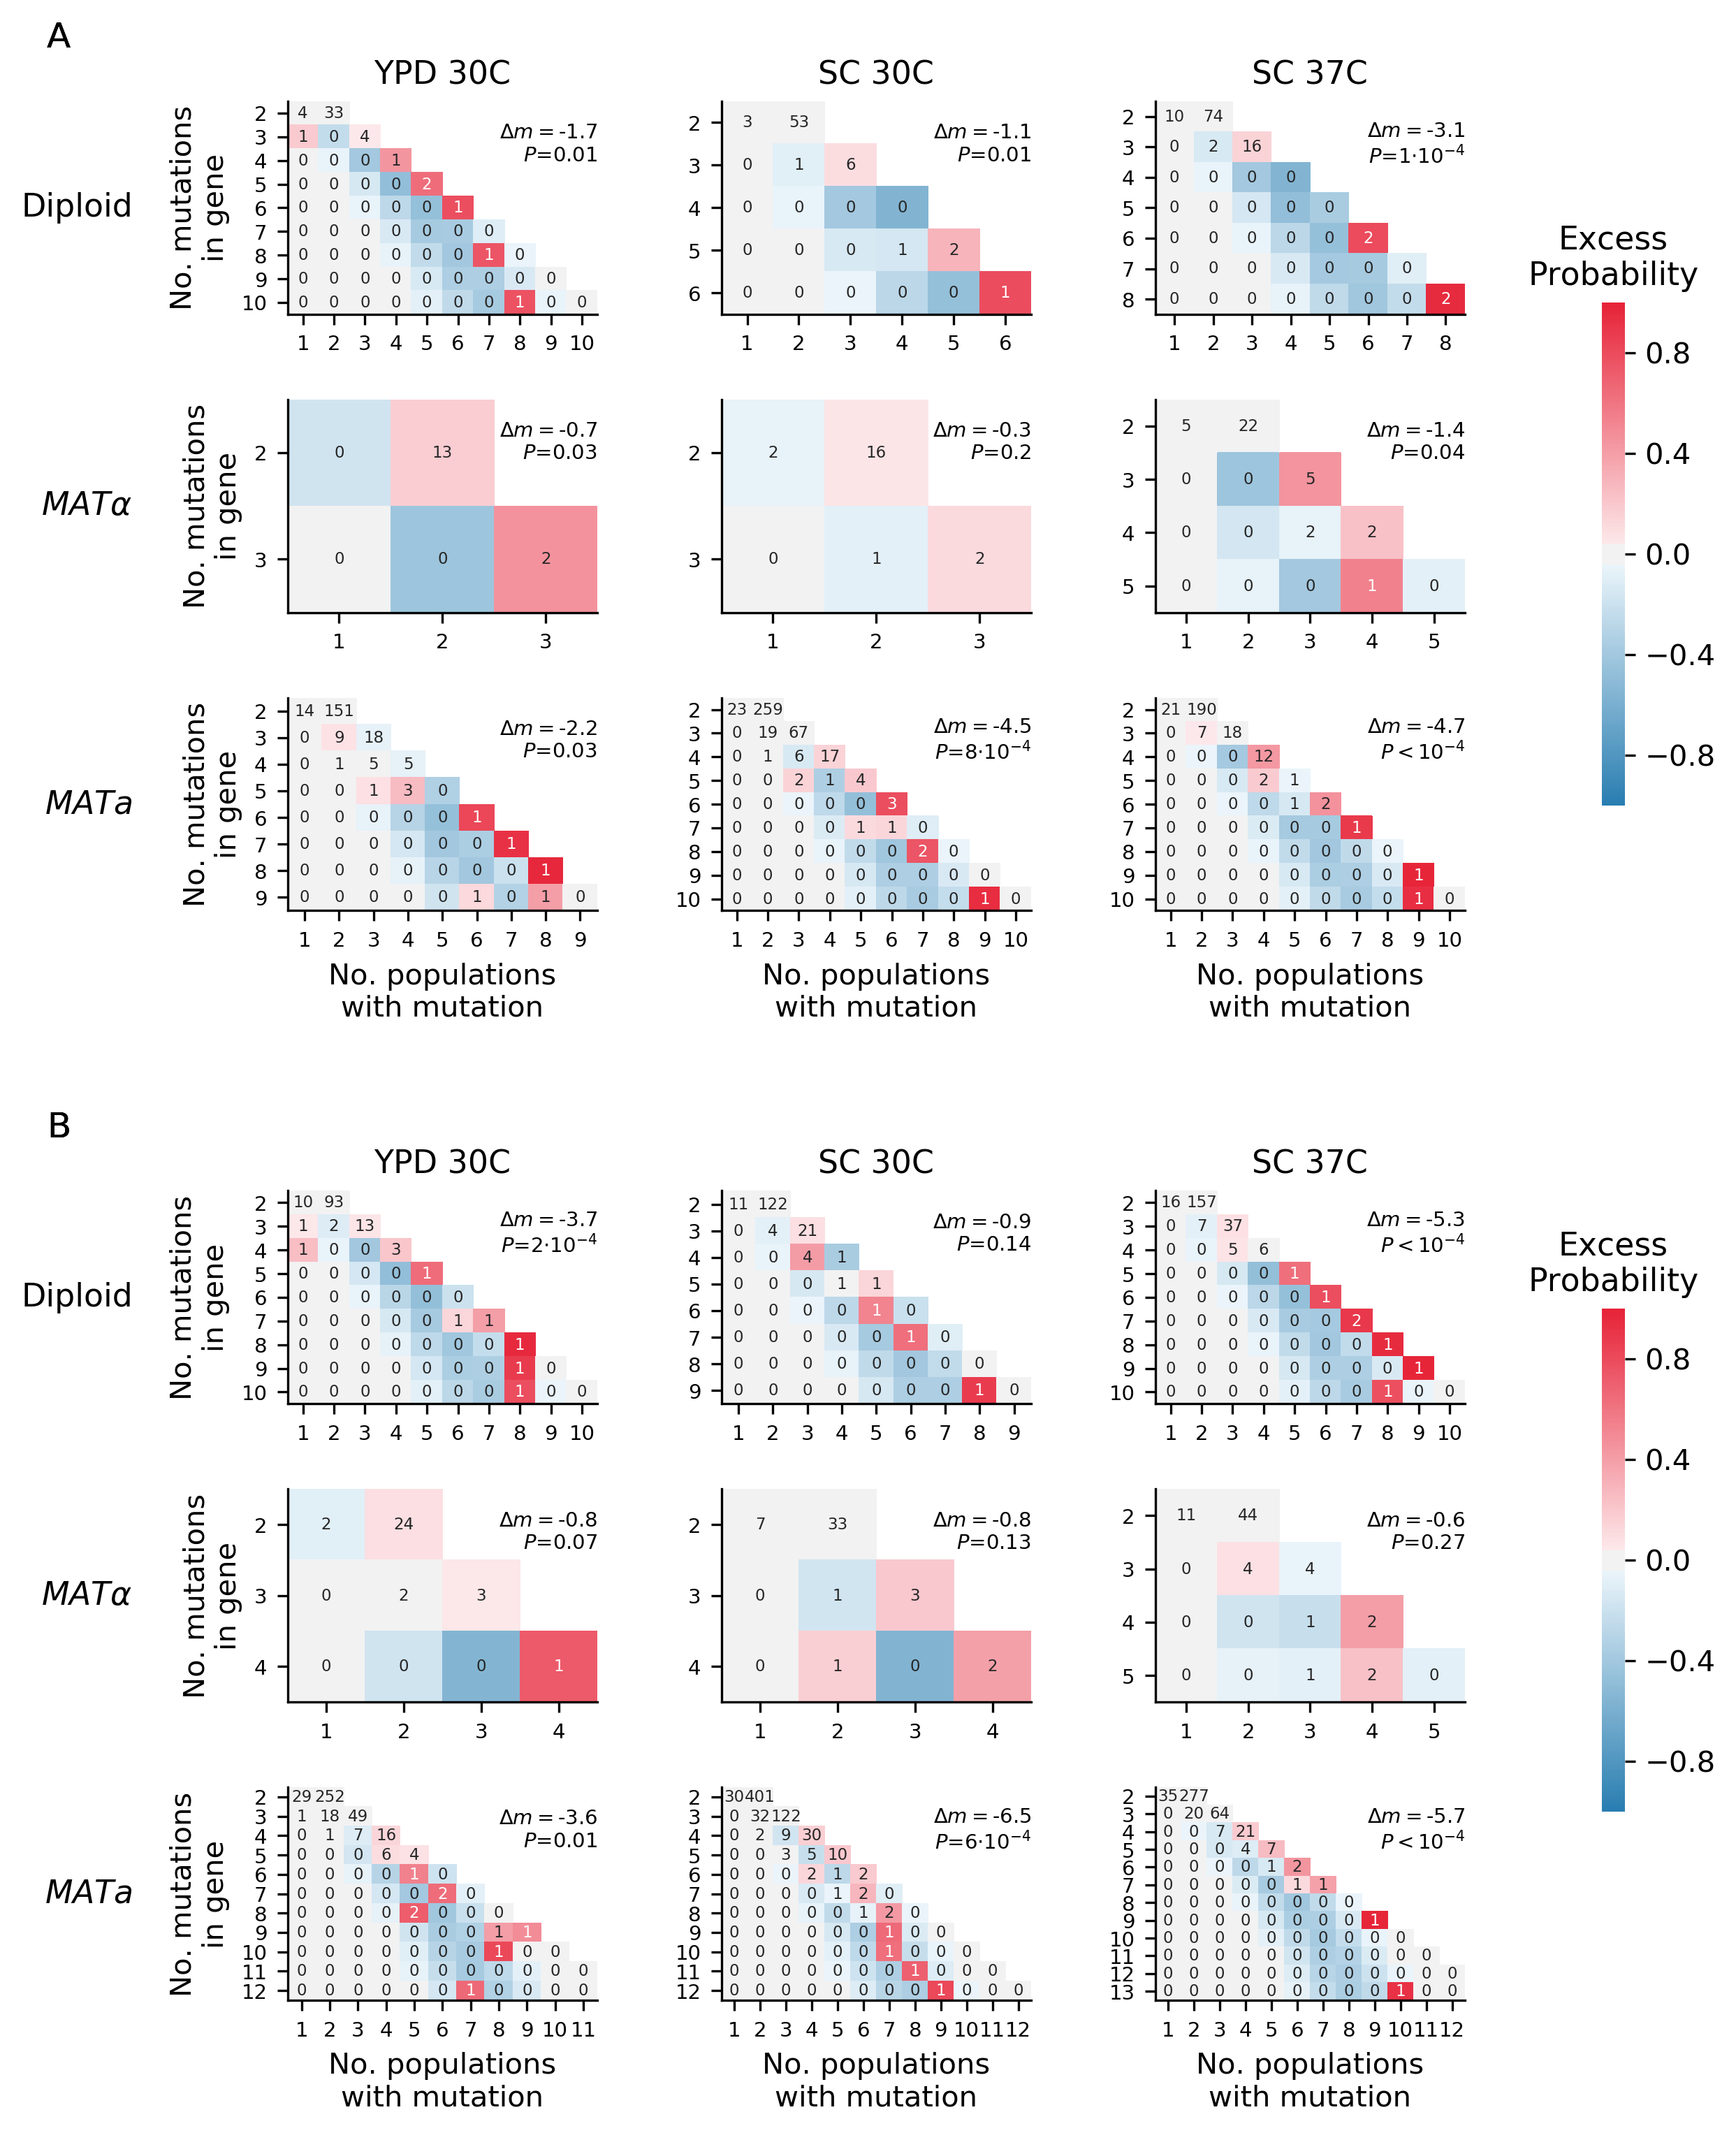

In [15]:
def multinomial_sim(pop_weights, max_hits, reps=10000):
    """
    weights are the weighted number of mutations in each populations
    max hits is the maximum number of hits we want to consider
    """
    sm = np.zeros((max_hits+1, len(pop_weights)+1))
    missed_op_probs = dict()
    for i in range(2, max_hits+1):
        draw = np.random.multinomial(i, pvals=pop_weights, size=reps)
        pops_hit = np.sum(np.clip(draw, 0, 1), axis=1)
        for ph in pops_hit:
            sm[i][ph] += 1
    
    smn = []
    for row in sm:
        smn.append(row/np.nansum(row))
    smn = np.nan_to_num(smn, nan=0)
    
    return sm, smn

def sim_missed_ops(genes_hit_mat, pop_weights, reps=10000):
    """
    weights are the weighted number of mutations in each populations
    max hits is the maximum number of hits we want to consider
    """
    no_hits = np.sum(genes_hit_mat, axis=1)
    results = []
    for i in no_hits:
        draw = np.random.multinomial(i, pvals=pop_weights, size=reps)
        pops_hit = np.sum(np.clip(draw, 0, 1), axis=1)
        redundant_mutations = i-pops_hit
        missed_ops = redundant_mutations*np.sum(np.clip(draw, 0, 1)*np.broadcast_to(pop_weights, (reps, pop_weights.shape[0])), axis=1)
        results.append(missed_ops)
    
    return np.sum(np.array(results), axis=0)

def get_gene_hit_dispersion_matrix(genes_hit_mat, pop_weights):
    """
    input: matrix with genes as rows, wells as columns, w the # times each gene is hit in each pop
    output: matrix with no. of mutations as rows and no. unique pops hit as columns, and the same matrix where rows sum to 1
    also outputs missed opportunities for each gene, defined as the probability of a random mutation hitting a population without this mutation (multinomial)
    multiplied by the number of redundant mutations (e.g. 5 mutations in only two populations = 3 redundant mutations)
    """
    no_hits = np.sum(genes_hit_mat, axis=1)
    pops_hit = np.sum(np.clip(genes_hit_mat, 0, 1), axis=1)
    redundant_mutations = no_hits-pops_hit
    prob_of_hitting_unhit_pop = np.sum(np.clip(genes_hit_mat, 0, 1)*np.broadcast_to(pop_weights, (genes_hit_mat.shape[0], pop_weights.shape[0])), axis=1)
    missed_ops = redundant_mutations*prob_of_hitting_unhit_pop
    bm = np.zeros((np.max(no_hits)+1, genes_hit_mat.shape[1]+1))
    for i in range(len(no_hits)):
        bm[no_hits[i]][pops_hit[i]] += 1

    bmn = []
    for row in bm:
        bmn.append(row/np.nansum(row))
    bmn = np.nan_to_num(bmn, nan=0)
    
    return bm, bmn, missed_ops
    
f = pl.figure(figsize=(7.25, 12), dpi=300)
pl.subplots_adjust(wspace=0.4, hspace=0.4)
gs0 = gridspec.GridSpec(9,1)
gses = [gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[:4,:]),gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[5:,:])]
suffixes = ['', '_present']
lets = ['A', 'B']
cbar_ax = [f.add_axes([.99, .6, .015, .2]), f.add_axes([.99, .2, .015, .2])]
for g in range(2):
    cbar_ax[g].set_title('Excess\nProbability', fontsize=11)
    subps = [[pl.Subplot(f, gses[g][i, j]) for j in range(3)] for i in range(3)]
    for p in range(3):
        plate = plates[p]
        for s in range(3):
            sub = subps[s][p]
            f.add_subplot(sub)
            strain = strains[s]
            use_wells = [w for w in wells if w[:2]==plate and well2strain[w]==strain]
            mutation_mat = np.array(orf_hit_df[[w+suffixes[g] for w in use_wells]])
            pop_weights = np.sum(mutation_mat, axis=0) / np.sum(mutation_mat)
            max_hits = np.max(np.sum(mutation_mat, axis=1))
            sim_counts, sim_res2 = multinomial_sim(pop_weights, max_hits)
            bm, bmn, missed_ops = get_gene_hit_dispersion_matrix(mutation_mat, pop_weights)
            miss_sim = sim_missed_ops(mutation_mat, pop_weights)
            
            mymap = sns.diverging_palette(240, 10, s=90, as_cmap=True)
            use = bmn-sim_res2
            x = np.min([len(pop_weights)+1, max_hits+1])
            y = max_hits+1
            mask=np.zeros_like(use)
            for i in range(y):
                for j in range(i+1,x):
                    mask[i,j]=1
                    
            #sub.add_patch(Rectangle((0, 0), x-1, y-2, fc='#DDDDDD', clip_on=False, zorder=-1))
            if p == 2 and s == 0:
                sns.heatmap(use[2:y,1:x], mask=mask[2:y,1:x], cmap=mymap, annot=bm[2:y,1:x], annot_kws={'size': 5.5}, fmt='g', ax=sub, center=0, vmax=1, vmin=-1, cbar_ax=cbar_ax[g], zorder=1)
            else:
                sns.heatmap(use[2:y,1:x], mask=mask[2:y,1:x], cmap=mymap, annot=bm[2:y,1:x], annot_kws={'size': 5.5}, fmt='g', ax=sub, center=0, vmax=1, vmin=-1, cbar=False, zorder=1)
            sub.set_xticks([i+0.5 for i in range(x-1)])
            sub.set_yticks([i+0.5 for i in range(y-2)])
            sub.set_xticklabels(list(range(1,x)), fontsize=7)
            sub.set_yticklabels(labels=list(range(2,y)), rotation='horizontal', fontsize=7)
            sub.set_ylim([y-2, 0])
            sub.set_xlim([0, x-1])
                      
            pval = len([m for m in miss_sim if m<=np.sum(missed_ops)])/len(miss_sim)
            if pval == 0:
                ps = '$<10^{-4}$'
            elif pval < 0.001:
                ps = '='+str(round(pval*10000))+'$\cdot 10^{-4}$'
            elif pval < 0.01:
                ps = '='+str(round(pval*1000))+'$\cdot 10^{-3}$'
            else:
                ps = '='+str(round(pval*100)/100)
                
            missed_op_ann = '$\Delta m=$'+str(np.sum(missed_ops)-np.mean(miss_sim))[:4]+'\n'+'$P$'+ ps
            sub.annotate(missed_op_ann, xy=(1, 0.8), xycoords="axes fraction", ha='right', va='center', fontsize=7)

            if s == 0:
                sub.set_title(plate2env[plate], y = 1.1, fontsize=11)
            elif s == 2:
                sub.set_xlabel('No. populations\nwith mutation', fontsize=10)
            if p == 0:
                sub.annotate(strains_for_print[strain], xy=(-0.5, 0.5), xycoords="axes fraction", ha='right', va='center', fontsize=11)
                sub.set_ylabel('No. mutations\nin gene', fontsize=10)
        subps[0][0].annotate(lets[g], xy=(-0.7, 1.3), xycoords="axes fraction", ha='right', va='center', fontsize=12)
                
sns.despine()

f.savefig('../../Output/Figs/supp_figs/Dispersion_and_missed_ops.png', background='transparent', bbox_inches='tight', pad_inches=0.1)
f.savefig('../../Output/Figs/supp_figs/Dispersion_and_missed_ops.svg', background='transparent', bbox_inches='tight', pad_inches=0.1)

## A little bit of poking around looking at underdispersed genes, didn't find anything convincingly interesting...

In [16]:
for p in range(3):
    plate = plates[p]
    for s in range(3):
        strain = strains[s]
        use_wells = [w for w in wells if w[:2]==plate and well2strain[w]==strain]
        orf_hit_df[plate+'_'+strain+'_Pops_present'] = np.sum(np.clip(orf_hit_df[[w+'_present' for w in use_wells]], 0, 1), axis=1)
        orf_hit_df[plate+'_'+strain+'_present_tot'] = np.sum(orf_hit_df[[w+'_present' for w in use_wells]], axis=1)
        orf_hit_df[plate+'_'+strain+'_present_dispersion'] = orf_hit_df[plate+'_'+strain+'_present_tot'] - orf_hit_df[plate+'_'+strain+'_Pops_present']

In [17]:
for p in range(3):
    plate = plates[p]
    for s in range(3):
        strain = strains[s]
        print(plate, strain)
        print(orf_hit_df.sort_values(by=plate+'_'+strain+'_present_dispersion', ascending=False)[['Gene_ORF', plate+'_'+strain+'_Pops_present', plate+'_'+strain+'_present_tot']].iloc[:7])

P1 diploid
       Gene_ORF  P1_diploid_Pops_present  P1_diploid_present_tot
1231  YMR173W-A                        1                       4
373       UBP12                        1                       3
394        ADE4                        8                      10
1152       CSC1                        1                       2
454       PHO23                        2                       3
99       HSP104                        8                       9
349        ADY3                        2                       3
P1 alpha
     Gene_ORF  P1_alpha_Pops_present  P1_alpha_present_tot
96       DYN1                      1                     2
417      SEF1                      2                     3
99     HSP104                      2                     3
283      REA1                      1                     2
0        RTG3                      0                     0
3105  YPL056C                      0                     0
3108     NTO1                      0           

## Checking it holds with my other method for simulating hits

In [18]:
def get_gene_hit_probs3(data, pop_hits):
    # Given a G x N array of G genes and N populations, 
    # with 1's where a population has a gene hit else 0's,
    # returns a matrix of probability of fixing in each population
    # based on the number of mutatations in each population (pop_hits, len N array)
    # and the number of populations with a mutation in that gene
    gene_hits = data.sum(axis=1)  + 0.1      # +0.1 pseudocount, pops w/ this gene hit, N_i
    total_hits = np.sum(pop_hits)             # total muts, M
    gene_hit_probs = gene_hits / total_hits   # N_i / M
    # TOO SLOW: prob_no_hits = np.array([[(1-i)**j for j in pop_hits] for i in gene_hit_probs])
    prob_no_hits = np.tile(1-gene_hit_probs, (len(pop_hits), 1)).T**np.tile(pop_hits, (len(gene_hits), 1)) 
    return 1-prob_no_hits

def split_probs3(pop_hits, mhd, well_sets):
    # given sets of well indices, computes hit probabilities separately for each set, 
    # then stitches them back together in order
    well_to_probs = dict()
    full_probs = np.zeros_like(mhd*1.1) # multiplication to force it to be a float array
    for well_set in well_sets:
        full_probs[:,well_set] = get_gene_hit_probs3(mhd[:,well_set], pop_hits[well_set])
    return full_probs

# here we fit probabilities of mutations happening in each background-environment combination using the data
model4_probs3 = split_probs3(pop_hits, mh_dat, [[w for w in range(len(wells)) if wells[w][:2]==p and well2strain[wells[w]]==s] for p in plates for s in strains])
# then we simulate mutations using this data, and calculate MI between multi-hit ORFs, recording the MI sum and max MI
sim_res3, sim_example3, sim3 = simulate_MI(1000, model4_probs3)

MI_tot P = 0.0


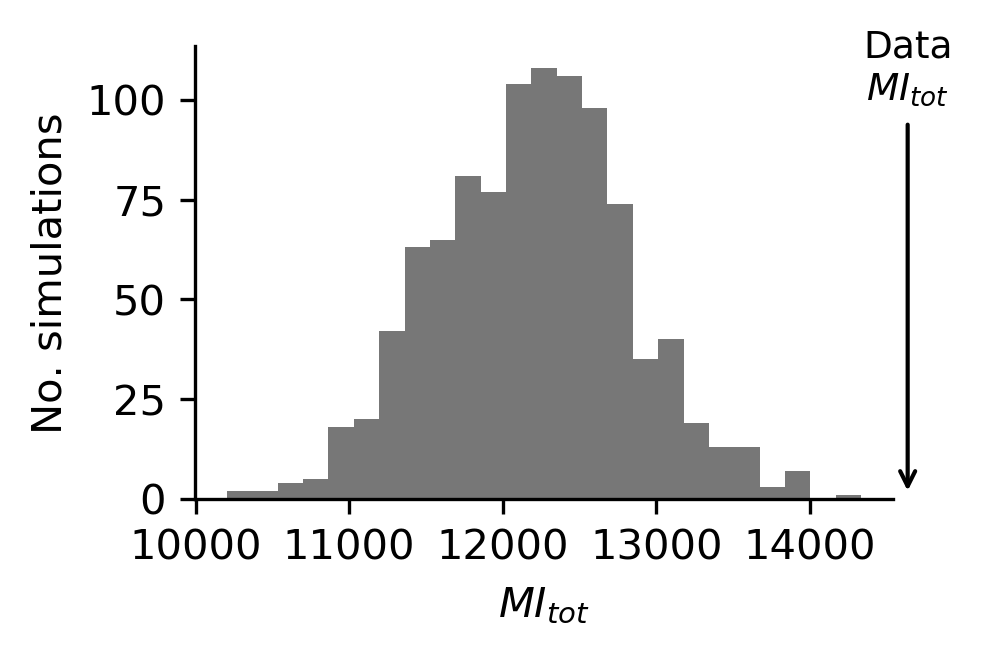

In [19]:
f, sub = pl.subplots(1, 1, figsize=(3, 2), dpi=300)
sub.hist([s[0] for s in sim_res3], bins=25, facecolor='#777777')
sub.annotate('Data\n$MI_{tot}$', xy=(np.sum(MI_results2), 0), xytext=(np.sum(MI_results2), 100), xycoords="data", ha='center', annotation_clip=False, arrowprops=dict(arrowstyle='->', lw=1), fontsize=9)
print('MI_tot P =', len([s[1] for s in sim_res3 if s[0]>np.sum(MI_results2)])/len(sim_res3))
sub.set_ylabel('No. simulations')
sub.set_xlabel('$MI_{tot}$')
sns.despine()
